<a href="https://colab.research.google.com/github/msiplab/EicEngLabIV/blob/master/example02_04.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 実験Ⅳ－２　時系列データのARモデル構築

1. サンプルデータの読み込み（訓練データとテストデータへの分割）
1. 原系列 $y_n$ の偏自己相関関数(PARCOR)のコレログラムとADF検定
1. 階差系列 $\Delta y_n=y_n-y_{n-1}$ の偏自己相関関数(PARCOR)のコレログラムとADF検定
1. ARモデルの係数パラメータ推定（訓練データ）
1. カルマンフィルタ（ARモデル）による時系列の推定（訓練データ）と予測（テストデータ）

参考図書

- 時系列解析入門／北川源四郎／岩波書店
- 時系列解析／島田直希／共立出版
- 時系列解析入門〔第２版〕／宮野尚哉・後藤田浩／サイエンス社

新潟大学工学部工学科　電子情報通信プログラム 

## 準備

In [86]:
!pip install pykalman
!pip install japanize-matplotlib
%matplotlib inline

import warnings
warnings.simplefilter('ignore') #警告を無視（コメントアウト推奨）

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import japanize_matplotlib #日本語化matplotlib
sns.set(font="IPAexGothic") #日本語フォント設定

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## サンプルデータの読み込み

CSV形式の河川水位観測データを読込


In [87]:
strtitle = '河川水位'
maxlag = 50 # hours

# ファイルをアップロードする
from google.colab import files
uploaded_file = files.upload()
filename = next(iter(uploaded_file))
print(filename)

#観測データのファイル
#filename = './data/practice02_01.csv'

#観測データ（空白区切り）の読み込み
df_full = pd.read_csv(filename)
df_full['t'] = pd.to_datetime(df_full['t'])
display(df_full)

Saving practice02_01_old.csv to practice02_01_old (1).csv
practice02_01_old.csv


,t,y
0,2019-07-23 01:00:00+09:00,42.08
1,2019-07-23 02:00:00+09:00,42.07
2,2019-07-23 03:00:00+09:00,42.11
3,2019-07-23 04:00:00+09:00,42.10
4,2019-07-23 05:00:00+09:00,42.12
...,...,...
8778,2020-07-22 19:00:00+09:00,43.76
8779,2020-07-22 20:00:00+09:00,43.67
8780,2020-07-22 21:00:00+09:00,43.55
8781,2020-07-22 22:00:00+09:00,43.34


## 時系列データをpandas.DataFrameオブジェクトに変換

pandas ライブラリの DataFrame オブジェクトに変換

- t: 時刻
- y: データの値

以下では，2020年3月1日0時～2020年3月31日23時までのデータで分析を進める。
訓練データ（推測用）とテストデータ（予測用）の割合を testdataratio で設定する。

- 訓練データ：テストデータ = (1-testdataratio) : testdataratio

In [88]:
# 解析期間の設定
dts = '2020030100' # 開始日時 
dte = '2020033123' # 終了日時
# テスト期間（後半）の割合
testdataratio = 0.2

# datetime 形式に変換
dts00 = pd.to_datetime(dts+'00').tz_localize('Asia/Tokyo')
dte00 = pd.to_datetime(dte+'00').tz_localize('Asia/Tokyo')
df_timeseries = df_full[(df_full.t>=dts00) & (df_full.t<=dte00)]
df_timeseries = df_timeseries.reset_index()
display(df_timeseries)
ntest = int(np.ceil(testdataratio*len(df_timeseries)))
ntrain = len(df_timeseries) - ntest
print('#訓練データ（前部） : #テストデータ（後部） = {0:d} : {1:d}'.format(ntrain,ntest))

,index,t,y
0,5327,2020-03-01 00:00:00+09:00,42.14
1,5328,2020-03-01 01:00:00+09:00,42.17
2,5329,2020-03-01 02:00:00+09:00,42.15
3,5330,2020-03-01 03:00:00+09:00,42.14
4,5331,2020-03-01 04:00:00+09:00,42.17
...,...,...,...
739,6066,2020-03-31 19:00:00+09:00,43.37
740,6067,2020-03-31 20:00:00+09:00,43.28
741,6068,2020-03-31 21:00:00+09:00,43.10
742,6069,2020-03-31 22:00:00+09:00,43.05


#訓練データ（前部） : #テストデータ（後部） = 595 : 149


## 欠損データの補間

データの欠損箇所があるため，前のデータで補間する。pandas.Series の以下のメソッドを利用できる。

- fillna(method='ffill')

In [89]:
df_timeseries['y_fillna'] = df_timeseries['y'].fillna(method='ffill').astype(float) 
display(df_timeseries)

,index,t,y,y_fillna
0,5327,2020-03-01 00:00:00+09:00,42.14,42.14
1,5328,2020-03-01 01:00:00+09:00,42.17,42.17
2,5329,2020-03-01 02:00:00+09:00,42.15,42.15
3,5330,2020-03-01 03:00:00+09:00,42.14,42.14
4,5331,2020-03-01 04:00:00+09:00,42.17,42.17
...,...,...,...,...
739,6066,2020-03-31 19:00:00+09:00,43.37,43.37
740,6067,2020-03-31 20:00:00+09:00,43.28,43.28
741,6068,2020-03-31 21:00:00+09:00,43.10,43.10
742,6069,2020-03-31 22:00:00+09:00,43.05,43.05


## 原系列 $y_n$ のプロット


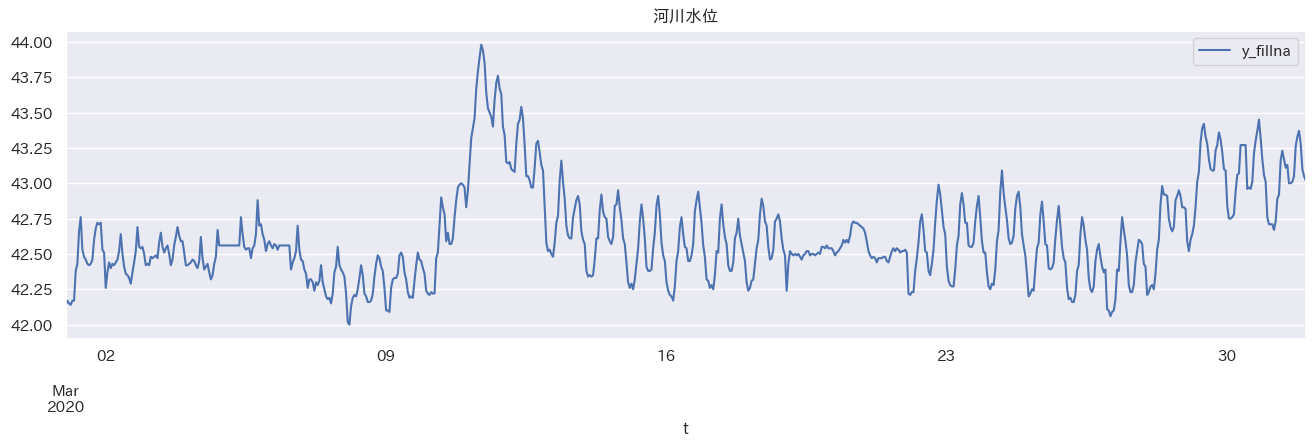

In [90]:
ax = df_timeseries.plot(x='t', y='y_fillna', figsize=(16,4), title=strtitle)


## 原系列 $y_n$ の自己相関関数

原系列 $y_n$ の時間依存性を確かめるために，自己相関関数のコレログラムを描画する。
自己相関関数のコレログラム描画にはstatsmodelsライブラリを利用できる。

- acf()
- plot_acf()

なお，コレログラム中の青色の帯は 95%信頼区間で，帯の外側の値を有意とみなす。


595

y_acf:
[1.         0.94955823 0.86197236 0.75917644 0.65682431 0.57830439
 0.53519279 0.53309554 0.56250847 0.60917658 0.65268944 0.67123039
 0.66447695 0.63484115 0.58141561 0.50785461 0.43408288 0.37888963
 0.35414416 0.36583986 0.40959696 0.47073088 0.53456995 0.58183354
 0.59420795 0.54088299 0.45258074 0.35532796]


Text(0.5, 0, 'lag')

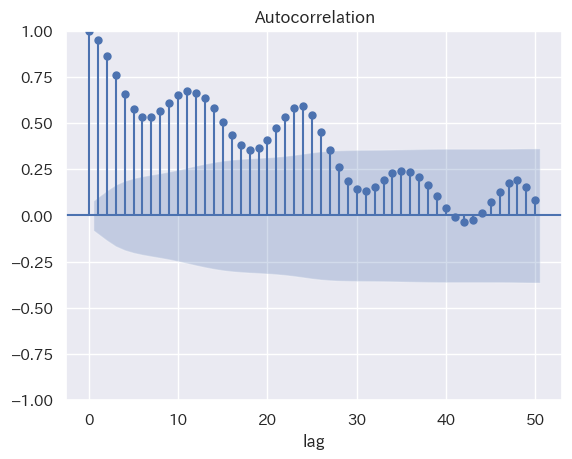

In [91]:
import statsmodels.api as sm
from statsmodels.tsa import stattools

y_series = df_timeseries['y_fillna'][:ntrain] # 訓練データ
display(len(y_series))
y_acf = sm.tsa.stattools.acf(y_series)
print('y_acf:')
print(y_acf)
fig = sm.graphics.tsa.plot_acf(y_series, lags=maxlag)
fig.axes[0].set_xlabel('lag')




## 原系列 $y_n$ の偏自己相関関数(PARCOR)

原系列 $y_n$ の時間依存性を確かめるために，偏自己相関関数(PARCOR)のコレログラムを描画する。
偏自己相関関数のコレログラム描画にはstatsmodelsライブラリを利用できる。

- pacf()
- plot_pacf()

y_pacf:
[ 1.          0.95115681 -0.41783279 -0.07515939  0.01831945  0.21469515
  0.20036555  0.22822833  0.11440029  0.07693852 -0.03152096 -0.13098181
  0.02869012  0.04333233 -0.07839384 -0.1809709  -0.01958906  0.07758641
  0.13738178  0.15608911  0.13272618  0.04867511  0.03343517 -0.04303476
 -0.0933782  -0.52732847 -0.03883551  0.09367847]


Text(0.5, 0, 'lag')

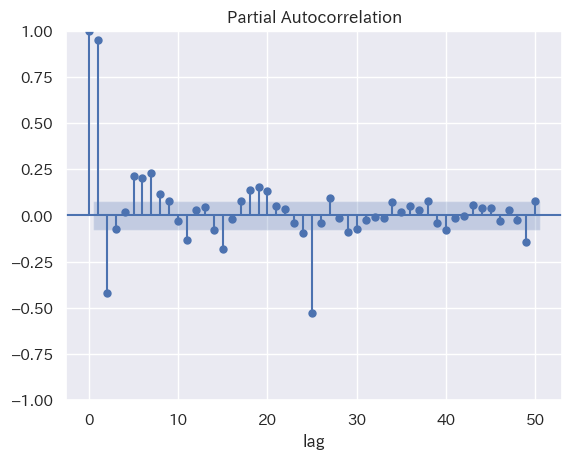

In [92]:
y_pacf = sm.tsa.stattools.pacf(y_series)
print('y_pacf:')
print(y_pacf)
fig = sm.graphics.tsa.plot_pacf(y_series, lags=maxlag)
fig.axes[0].set_xlabel('lag')


## 原系列 $y_n$ の定常性の検証

PARCORのコレログラムから24時間間隔での有意な偏相関がみられる。絶対値は1以下なので単位根過程か否かを検証する。

原系列 $y_n$ が定常過程であるかを確認するため，ADF(augmented Dickey-Fuler)検定を実施する。


ADF検定では，
- 帰無仮説 $H_0: \rho=1$（単位根過程）
- 対立仮説 $H_1: 0<\rho <1$ （弱定常過程）

として検定を行う。

帰無仮説が正しいにも関わらず，帰無仮説を棄却する誤りの確率をp値(p-value)という。このp値がある有意水準（significant level）より小さければ，帰無仮説を棄却し，対立仮説を受容する。すなわち，ADF検定のp値が高いと単位根過程であるという仮説を棄却できない（定常過程であるといえない）。





In [93]:
y_adftest = stattools.adfuller(y_series)
print('y_adftest:')
print(y_adftest)

y_adftest:
(-1.9279250950686206, 0.31904042318986947, 19, 575, {'1%': -3.4417738839904657, '5%': -2.8665796253604015, '10%': -2.569453974291115}, -1323.2106597242664)


## 階差系列 $\Delta y_n$ のプロット

ADF検定結果の2番目の値がp値。原系列 $y_n$ のADF検定の結果，p値が有意水準0.05 よりも大きいため単位根過程という仮説を棄却できない。

そこで，階差系列

$\Delta y_n=y_n-y_{n-1}$
    
の分析を進める。





,index,t,y,y_fillna,y_fillna_diff
0,5327,2020-03-01 00:00:00+09:00,42.14,42.14,NaN
1,5328,2020-03-01 01:00:00+09:00,42.17,42.17,0.03
2,5329,2020-03-01 02:00:00+09:00,42.15,42.15,-0.02
3,5330,2020-03-01 03:00:00+09:00,42.14,42.14,-0.01
4,5331,2020-03-01 04:00:00+09:00,42.17,42.17,0.03
...,...,...,...,...,...
739,6066,2020-03-31 19:00:00+09:00,43.37,43.37,0.04
740,6067,2020-03-31 20:00:00+09:00,43.28,43.28,-0.09
741,6068,2020-03-31 21:00:00+09:00,43.10,43.10,-0.18
742,6069,2020-03-31 22:00:00+09:00,43.05,43.05,-0.05


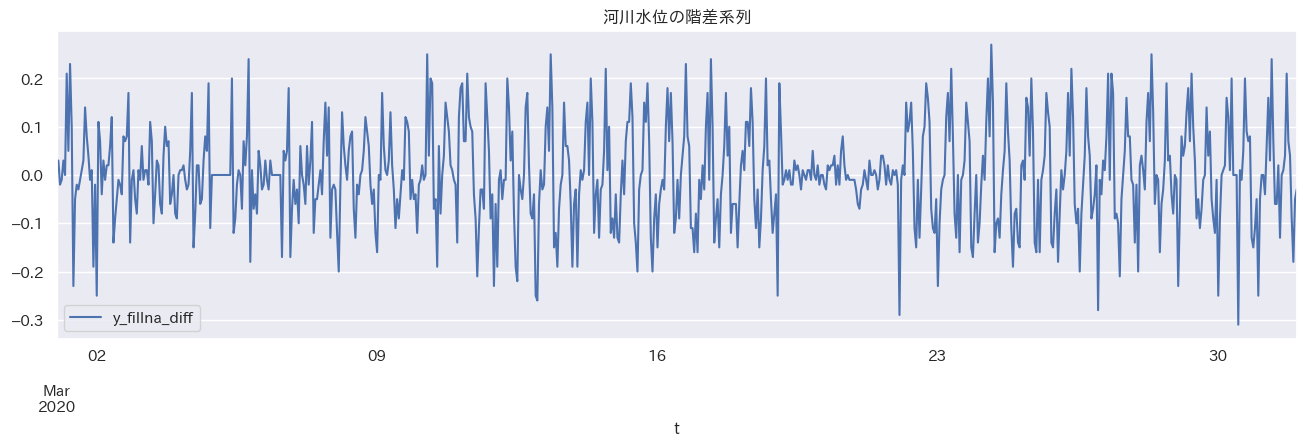

In [94]:
df_timeseries['y_fillna_diff'] = df_timeseries['y_fillna'].diff()
display(df_timeseries)
ax = df_timeseries.plot(x='t', y='y_fillna_diff', figsize=(16,4), title=strtitle+'の階差系列')

## 階差系列 $\Delta y_n$ の自己相関関数

階差系列 $\Delta y_n$ の時間依存性を確かめるために，自己相関関数のコレログラムを描画する。

先頭の値のみ非数(nan)であるため，dropna() で削除する．




1      0.03
2     -0.02
3     -0.01
4      0.03
5      0.00
       ... 
590   -0.01
591    0.01
592    0.04
593    0.17
594    0.13
Name: y_fillna_diff, Length: 594, dtype: float64

y_fillna_diff_acf:
[ 1.          0.38937422  0.16011605 -0.00430419 -0.24321699 -0.36570011
 -0.41061976 -0.32136288 -0.16379543  0.03672769  0.2413585   0.26260718
  0.23560557  0.24702843  0.21155893  0.00273856 -0.18834967 -0.30206962
 -0.37370359 -0.33151993 -0.18210404 -0.02937052  0.1499789   0.35514577
  0.65818497  0.37242055  0.10348565 -0.01669113]


Text(0.5, 0, 'lag')

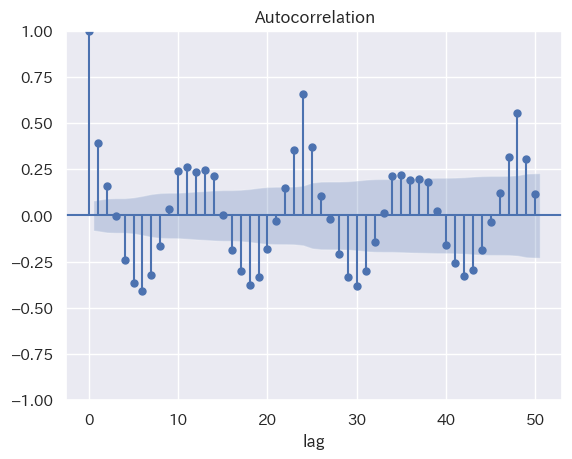

In [95]:
y_diff_series = df_timeseries['y_fillna_diff'][:ntrain].dropna()
display(y_diff_series)
y_fillna_diff_acf = sm.tsa.stattools.acf(y_diff_series)
print('y_fillna_diff_acf:')
print(y_fillna_diff_acf)
fig = sm.graphics.tsa.plot_acf(y_diff_series, lags=maxlag)
fig.axes[0].set_xlabel('lag')

## 階差系列 $\Delta y_n$ の偏自己相関関数(PARCOR)

階差系列 $\Delta y_n$ の時間依存性を確かめるために，偏自己相関関数(PARCOR)のコレログラムを描画する。

y_fillna_diff_pacf:
[ 1.00000000e+00  3.90030838e-01  1.00638895e-02 -8.29000354e-02
 -2.58464356e-01 -2.30379993e-01 -2.28570004e-01 -1.28744240e-01
 -6.69610308e-02  1.87421365e-02  9.89963194e-02 -2.79814075e-02
 -4.48673983e-02  8.23910630e-02  1.72144306e-01 -3.91810228e-03
 -9.80068712e-02 -1.31481941e-01 -1.65667381e-01 -1.31710011e-01
 -4.82593738e-02 -3.68302593e-02  2.83407262e-05  9.71132194e-02
  4.95454430e-01  4.65922549e-02 -1.11446071e-01 -1.29974006e-02]


Text(0.5, 0, 'lag')

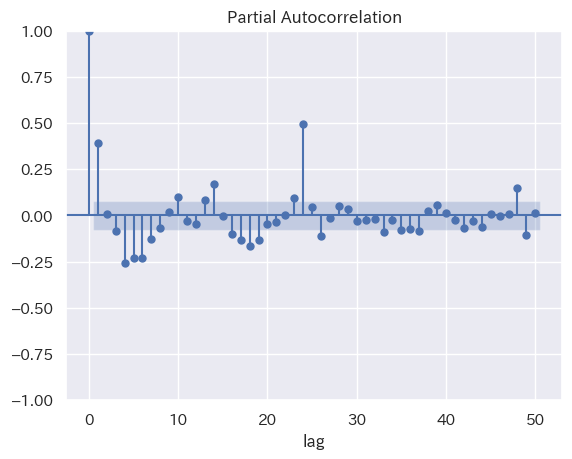

In [96]:
y_fillna_diff_pacf = sm.tsa.stattools.pacf(y_diff_series)
print('y_fillna_diff_pacf:')
print(y_fillna_diff_pacf)
fig = sm.graphics.tsa.plot_pacf(y_diff_series, lags=maxlag)
fig.axes[0].set_xlabel('lag')

## 階差系列 $\Delta y_n$ の定常性の検証

PARCORのコレログラムから24時間間隔での有意な偏相関がみられる。絶対値は1以下なので単位根過程か否かを検証する。定常性の検証にADF検定を実施する。

In [97]:
y_diff_adftest = stattools.adfuller(y_diff_series)
print('y_diff_adftest:')
print(y_diff_adftest)

y_diff_adftest:
(-8.775369089640684, 2.4571193002315514e-14, 18, 575, {'1%': -3.4417738839904657, '5%': -2.8665796253604015, '10%': -2.569453974291115}, -1318.0647299098405)


## 階差系列 $\Delta y_n$ のARモデルの構築

ADF検定結果の2番目の値がp値。階差系列 $\Delta y_n$ のADF検定の結果，p値が有意水準0.05 よりも小さいため単位根過程という仮説を棄却する。結果として定常過程であることを確認できたため階差系列 $\Delta y_n$ のARモデルを構築する。

ARモデルの構築に statsmodels ライブラリの ar_model モジュールを利用する。

なお、デフォルトでは定数 $a_0$ を考慮したモデル

$v_n = a_0 + \sum_{k=1}^{p}a_k v_{n-k}+w_n$, $w_n\sim N(0,\sigma^2)$

が採用される。

statsmodels の ar_model.ar_select_order では、引数 ic に 'aic' を指定すると、 maxlag までの次数の中で最小AIC法により次数pの選択がなされる。

In [98]:
from statsmodels.tsa import ar_model
# ARモデルのインスタンス生成
arpmodel = ar_model.ar_select_order(y_diff_series,maxlag,ic='aic')
# ARモデルの最適次数推定
ords = arpmodel.ar_lags
popt = max(ords)
print('popt = {:2d}'.format(popt))

popt = 26


## ARモデルの評価

残差とそのPARCORの表示


Text(0.5, 0, 'lag')

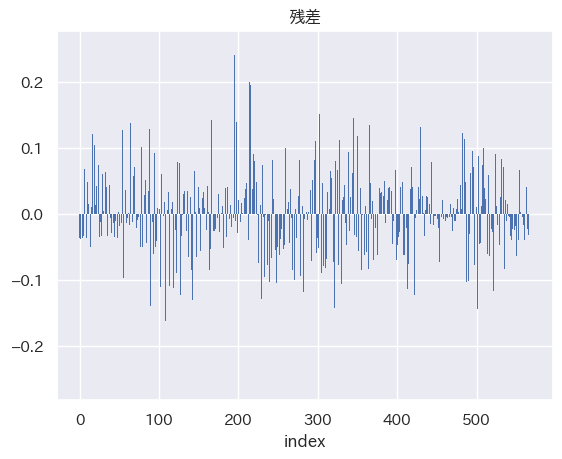

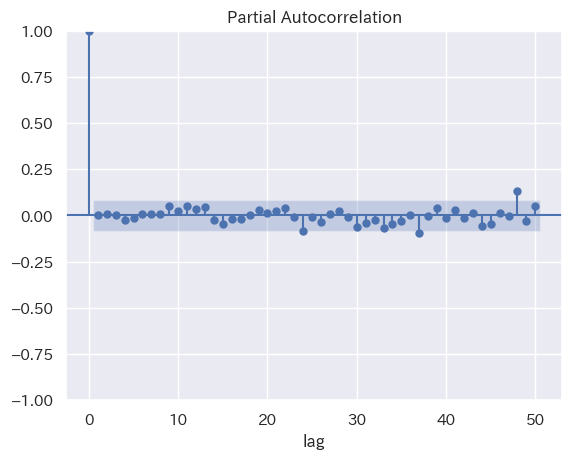

In [99]:
# ARモデルの係数パラメータ推定
results = ar_model.AutoReg(y_diff_series,ords).fit()
residual = results.resid
# 残差のプロット
fig, ax = plt.subplots()
bc = plt.bar(range(len(residual)), residual, edgecolor='none')
ax.set_title('残差')
ax.set_xlabel('index')
# 残差のPARCOR
fig = sm.graphics.tsa.plot_pacf(residual, lags=maxlag)
fig.axes[0].set_xlabel('lag')



## ARモデルによる推定と予測結果

- 実線：階差系列 $\Delta y_n$
- 破線：ARモデルによる推定と予測 



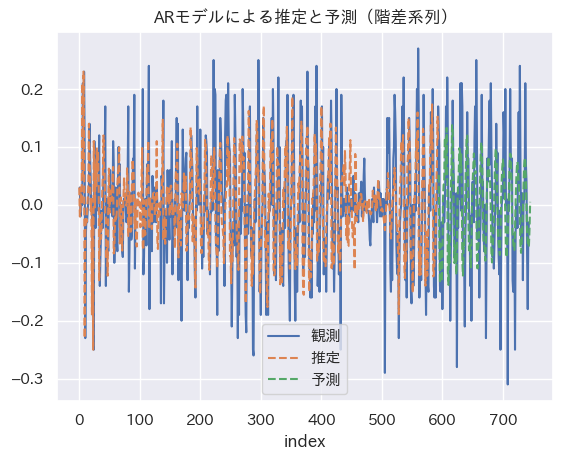

In [100]:
# 階差系列 （訓練データ区間＋テストデータ区間）
y_diff_orig = df_timeseries['y_fillna_diff']
fig, ax = plt.subplots()
ax.set_title('ARモデルによる推定と予測（階差系列）')
ax.set_xlabel('index')
plt.plot(y_diff_orig, label='観測')
# ARモデルの推定（訓練データ区間）
plt.plot(np.hstack([y_diff_series[:popt],results.fittedvalues]),'--',label='推定')
# ARモデルの予測（テストデータ区間）
plt.plot(results.predict(ntrain-1,ntrain+ntest+1,dynamic=True),'--',label='予測')
# 凡例
plt.legend()


## カルマンフィルタとしてのARモデル

定数 $a_0$ を考慮したモデル。

- 状態ベクトル
$\boldsymbol{x}_{n}=\left(\begin{array}{lllll}
v_{n} & \left(a_{2} v_{n-1}+\cdots+a_{p} v_{n-p+1}\right) & \cdots & \left(a_{p-1} v_{n-1}+a_{p} v_{n-2}\right) & a_{p} v_{n-1} & a_0
\end{array}\right)^{T}$
- 推移行列
$\boldsymbol{F}_{n}=\left(\begin{array}{cccccc}
a_{1} & 1 & \cdots & 0 & 0 & 0 \\
a_{2} & 0 & \ddots & 0 & 0 & 0  \\
\vdots & \vdots & \ddots & \vdots & \vdots & \vdots \\
a_{p-1} & 0 & \cdots & 0 & 1 & 0\\
a_{p} & 0 & \cdots & 0 & 0 & 0\\
0 & 0 & \cdots & 0 & 0  & 1
\end{array}\right)$
- 係数行列
$\boldsymbol{G}_{n}=\left(\begin{array}{c}
1 \\
0 \\
\vdots \\
0 \\
0 
\end{array}\right)$,
- 観測行列
$\boldsymbol{H}_{n}=\left(\begin{array}{cccccc}
1 & 0 & \cdots & 0 & 0 & 1
\end{array}\right)$,
- システムノイズの分散
$\boldsymbol{Q}_{n}=\sigma^{2}$, 
- 観測ノイズの分散
$\boldsymbol{R}_{n}=0$

上記は系列 $v_n$ を対象とした標記のため階差系列 $\Delta y_n$ に適用する際には　$v_n$ を $\Delta y_n$ と読替える。


In [101]:
n_dim_state = popt+1
ar_const = results.params[0]
ar_coefs = results.params[1:].to_numpy()

# 推移行列
f1 = ar_coefs.reshape(-1,1)
f2 = np.eye(popt)
f2[-1,-1] = 0.
f3 = np.zeros((1,n_dim_state))
f3[-1,-1] = 1.
F = np.block([ [f1, f2], [f3] ])
print('F = ')
print(F)

# 係数行列
G = np.zeros((n_dim_state,1))
G[0,0] = 1.
print('G = ')
print(G)

# 観測行列
H = np.zeros((1,n_dim_state))
H[0,0] = 1.
H[-1,-1] = 1.
print('H = ')
print(H)

# システムノイズの分散
Q = results.sigma2
print('Q = ')
print(Q)

# 観測ノイズの分散
R = 0.

F = 
[[ 0.08095553  1.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.04145389  0.          1.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.05864916  0.          0.          1.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [-0.09925367  0.          0.          0.          1.          0.
   0.          0.   

## カルマンフィルタオブジェクト生成

pykalman ライブラリを使用

インストール方法は以下の通り

\$ pip install pykalman

In [102]:
from pykalman import KalmanFilter

# 観測値の次元数
n_dim_obs = 1
# 状態の平均ベクトルの初期値
initial_state_mean = ar_const*np.ones(n_dim_state)
# 状態の分散共分散行列の初期値
initial_state_covariance = np.eye(n_dim_state)

# カルマンフィルタによるARモデル生成
kf = KalmanFilter(
        n_dim_obs=n_dim_obs,
        n_dim_state=n_dim_state,
        initial_state_mean=initial_state_mean,
        initial_state_covariance=initial_state_covariance,
        transition_matrices=F,
        observation_matrices=H,
        observation_covariance=R,
        transition_covariance=G.dot(Q).dot(G.T)
)


## カルマンフィルタ（ARモデル）による推定と予測結果

- 実線：階差系列 $\Delta y_n$
- 破線：ARモデルによる推定と予測 

観測結果を予測に反映するため推定精度が向上する。

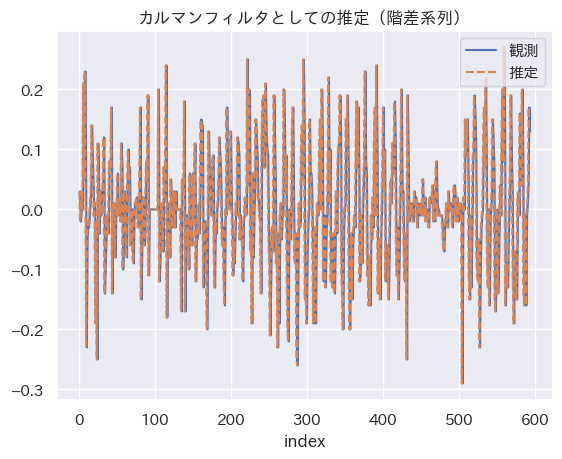

In [103]:
# 訓練データ
y_diff_train = df_timeseries['y_fillna_diff'][:ntrain].dropna()

# フィルタ
filtered_state_means, filtered_state_covs = kf.filter(y_diff_train)
# 訓練データの推定値
y_diff_filtered_pred = filtered_state_means.dot(H.T)

# プロット
fig, ax = plt.subplots()
ax.set_title('カルマンフィルタとしての推定（階差系列）')
ax.set_xlabel('index')
# ARモデルの予測（訓練データ区間）
plt.plot(y_diff_train, label='観測')
plt.plot(y_diff_filtered_pred, '--', label='推定')
# 凡例
plt.legend()

## カルマンフィルタとしての長期予測


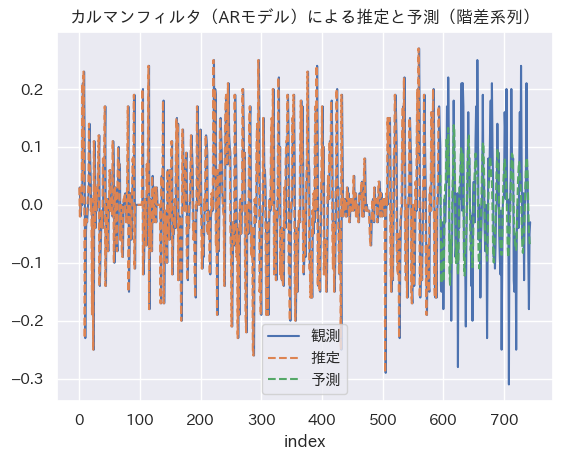

In [104]:
# テストデータ
y_diff_test = df_timeseries['y_fillna_diff'][ntrain:]

# 現在の状態と分散共分散行列を取得
current_state = filtered_state_means[-1]
current_cov = filtered_state_covs[-1]

y_diff_forecast = np.empty(len(y_diff_test))
for idx in range(len(y_diff_test)):
    # filtere_update で 1期先予測を実行(observation=None)
    current_state, current_cov = kf.filter_update(
        current_state,current_cov,observation=None)
    y_diff_forecast[idx] = current_state.dot(H.T)

# 階差系列 （訓練データ区間＋テストデータ区間）
y_diff_orig = df_timeseries['y_fillna_diff'].dropna()
# プロット
fig, ax = plt.subplots()
ax.set_title('カルマンフィルタ（ARモデル）による推定と予測（階差系列）')
ax.set_xlabel('index')
# 観測
plt.plot(y_diff_orig, label='観測')
# ARモデルの推定（訓練データ区間）
plt.plot(y_diff_filtered_pred, '--', label='推定')
# ARモデルの予測（テストデータ区間）
plt.plot(np.arange(ntrain,ntrain+ntest),y_diff_forecast, '--', label='予測')
# 凡例
plt.legend()


## 原系列 $y_n$ との比較

階差系列の予測 $\widehat{\Delta y_n}$ を累積加算し、その結果に初期実測値 $y_0$を加えて原系列と比較する。

$\hat{y}_n = y_0 + \sum_n \widehat{\Delta y_n}$

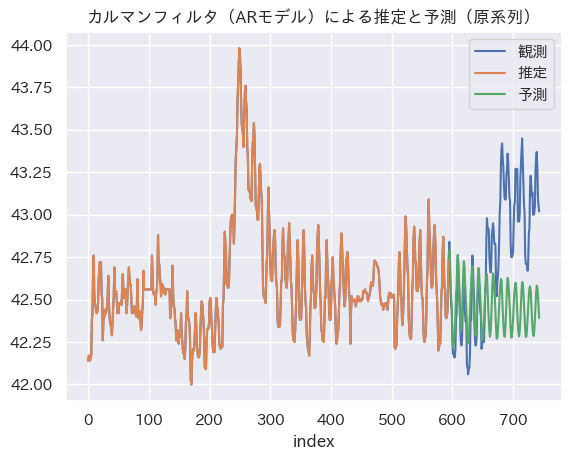

In [105]:
# 原系列 （訓練データ区間＋テストデータ区間）
y_orig = df_timeseries['y_fillna']
fig, ax = plt.subplots()
ax.set_title('カルマンフィルタ（ARモデル）による推定と予測（原系列）')
ax.set_xlabel('index')
plt.plot(y_orig, label='観測')
# 推定値の先頭に水位観測の初期値を追加して累積加算
y0 = y_orig[0]
y_filtered_pred = np.insert(y_diff_filtered_pred, 0, y0).cumsum()
plt.plot(y_filtered_pred,label='推定')
# 予測値の先頭に水位推定値の最終値を追加して累積加算
y_filtered_forecast = np.insert(y_diff_forecast, 0, y_filtered_pred[-1]).cumsum()
plt.plot(np.arange(ntrain-1,ntrain+ntest),y_filtered_forecast,label='予測')
# 凡例
plt.legend()